In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
tf.compat.v1.enable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
tf.version.VERSION

'2.14.0'

In [ ]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# Ecuación de convección 1D
## PDE Condition
$\phi_t + u\phi_x=0, (x,t)\in(0,1)^2$

$\phi(t,0)=\phi(t,1), t\in(0,1)$

$\phi(0,x)=sin(2\pi x /L), x\in(0,1)$

Donde **u** es la velocidad, un valor escalar constante.






## Código

In [ ]:
DTYPE='float32'

U=1
L=1
pi = tf.constant(np.pi, dtype=DTYPE)
def fun_u_0(x):
  return tf.sin(2*pi*x)

def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
# Define residual of the PDE
def fun_r(t, x, u, u_t,u_x):
    return u_t+u_x

In [ ]:
# Data points
N_0=500
N_b=500
N_r=10000

# Boundary
tmin=0
tmax=1
xmin=0
xmax=1

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    model.summary()
    return model

In [ ]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
    del tape

    return fun_r(t, x, u, u_t, u_x)

In [ ]:
def symmetry(tensor):
  tiempo=tf.map_fn(lambda x: x[0], tensor)
  espacio=tf.map_fn(lambda x: x[1], tensor)
  espacio=tf.where(tf.equal(espacio, lb[1]), ub[1], lb[1])
  mm=tf.stack((tiempo, espacio), axis=1)
  return mm

In [ ]:
symmetry(X_data[1])

<tf.Tensor: shape=(500, 2), dtype=float32, numpy=
array([[9.84029174e-01, 1.00000000e+00],
       [4.37847495e-01, 1.00000000e+00],
       [7.76127577e-01, 0.00000000e+00],
       [5.94760180e-01, 1.00000000e+00],
       [4.35985327e-01, 1.00000000e+00],
       [6.47500634e-01, 1.00000000e+00],
       [4.01897669e-01, 0.00000000e+00],
       [6.60846949e-01, 1.00000000e+00],
       [3.78206968e-01, 1.00000000e+00],
       [3.04292321e-01, 0.00000000e+00],
       [8.74794126e-01, 0.00000000e+00],
       [6.97362661e-01, 0.00000000e+00],
       [4.32121515e-01, 1.00000000e+00],
       [1.74571991e-01, 0.00000000e+00],
       [4.28969979e-01, 1.00000000e+00],
       [8.66913319e-01, 1.00000000e+00],
       [3.16202641e-01, 0.00000000e+00],
       [5.17037034e-01, 1.00000000e+00],
       [6.21696830e-01, 0.00000000e+00],
       [5.43296099e-01, 1.00000000e+00],
       [6.23387575e-01, 0.00000000e+00],
       [5.96774220e-01, 1.00000000e+00],
       [3.99355769e-01, 0.00000000e+00],
       

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    u_pred = model(X_data[0])
    loss += tf.reduce_mean(tf.square(u_data[0] - u_pred))

    symmetry_b=symmetry(X_data[1])
    loss += tf.reduce_mean(tf.square(model(X_data[1])-model(symmetry_b)))
    # Podrian restarse los boundaries, así estan mal calculados
    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
mlp = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,4000],[1e-1,1e-2,5e-4])

# Choose the optimizer
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
optim=tf.keras.optimizers.Adam()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                4

## Entrenamiento

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(mlp, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, mlp.trainable_variables))

    return loss

# Number of training epochs
N = 6000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.20058465e+00
It 00050: loss = 4.02703106e-01
It 00100: loss = 2.67894298e-01
It 00150: loss = 1.89421728e-01
It 00200: loss = 1.37225866e-01
It 00250: loss = 1.21264458e-01
It 00300: loss = 1.10080242e-01
It 00350: loss = 9.05642435e-02
It 00400: loss = 5.08696958e-02
It 00450: loss = 2.04490311e-02
It 00500: loss = 1.05066206e-02
It 00550: loss = 5.78927714e-03
It 00600: loss = 6.90017221e-03
It 00650: loss = 2.37215403e-03
It 00700: loss = 2.84544751e-03
It 00750: loss = 1.15603697e-03
It 00800: loss = 2.91287340e-03
It 00850: loss = 6.64594118e-04
It 00900: loss = 1.15249236e-03
It 00950: loss = 4.32718021e-04
It 01000: loss = 5.18170279e-03
It 01050: loss = 3.41534644e-04
It 01100: loss = 2.85265531e-04
It 01150: loss = 2.52568279e-04
It 01200: loss = 3.29828385e-04
It 01250: loss = 2.07051125e-04
It 01300: loss = 1.86144913e-04
It 01350: loss = 3.16150341e-04
It 01400: loss = 2.15675027e-04
It 01450: loss = 1.44664591e-04
It 01500: loss = 2.24216725e-04
It 01550

## Solución

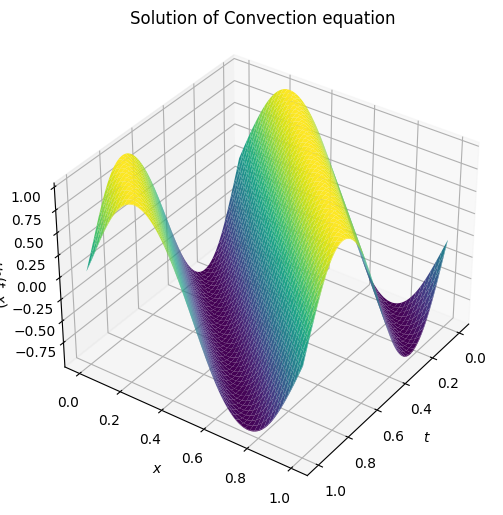

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = mlp(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Convection equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

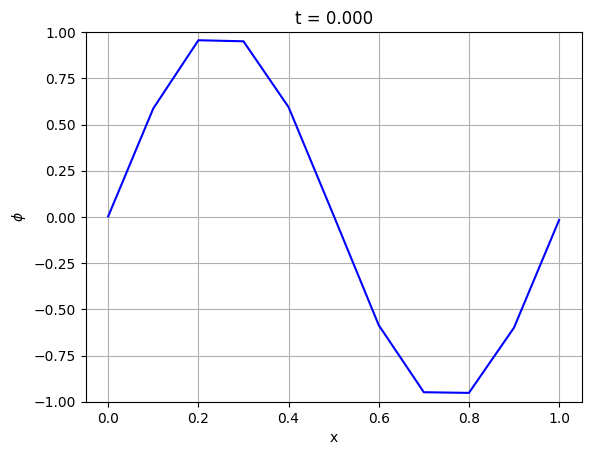

In [ ]:
# Set up meshgrid
N = 10
N_t=100
ps=[]
tspace = np.linspace(lb[0], ub[0], N_t + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)

from matplotlib import animation, rc
rc('animation', html='html5')

def update(i):
    ax.clear()
    ax.set_ylim(-1,1)
    T, X = np.meshgrid(tspace[i], xspace)
    Xgrid = np.vstack([T.flatten(),X.flatten()]).T
    upred=[]
    upred = mlp(tf.cast(Xgrid,DTYPE))
    upred=np.squeeze(upred.numpy())
    ax.plot(xspace,upred, "b")
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
    ax.set_title(f't = {tspace[i]:.3f}')
    ax.grid(True)
    return ax

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(tspace), interval=200)
anim

# The One-Dimensional Heat Equation
$u_t=3u_{xx}; \thinspace (0 < x < 2, t>0)$

$u(t,0)=u(t,2)=0; \thinspace (t >0)$

$u(0,x)=50; (0 < x <2)$


## Código

In [ ]:
def fun_u_0(x):
  return 0*x+50

DTYPE='float32'

def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
# Define residual of the PDE
def fun_r(t, x, u, u_t, u_xx):
    return u_t-3*u_xx

In [ ]:
# Data points
N_0=500
N_b=500
N_r=10000

# Boundary
tmin=0
tmax=1
xmin=0
xmax=2

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    model.summary()
    return model

In [ ]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_xx)

In [ ]:
def symmetry(tensor):
  tiempo=tf.map_fn(lambda x: x[0], tensor)
  espacio=tf.map_fn(lambda x: x[1], tensor)
  espacio=tf.where(tf.equal(espacio, lb[1]), ub[1], lb[1])
  mm=tf.stack((tiempo, espacio), axis=1)
  return mm

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    u_pred = model(X_data[0])
    loss += tf.reduce_mean(tf.square(u_data[0] - u_pred))

    u_pred=model(X_data[1])
    loss += tf.reduce_mean(tf.square(u_data[1]-u_pred))
    # Podrian restarse los boundaries, así estan mal calculados
    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
mlp = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,4000],[1e-1,1e-2,5e-4])

# Choose the optimizer
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
optim=tf.keras.optimizers.Adam()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                4

## Entrenamiento

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(mlp, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, mlp.trainable_variables))

    return loss

# Number of training epochs
N = 6000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.47835059e+03
It 00050: loss = 2.03393262e+03
It 00100: loss = 1.85413831e+03
It 00150: loss = 1.74450574e+03
It 00200: loss = 1.63571973e+03
It 00250: loss = 1.54020264e+03
It 00300: loss = 1.45253027e+03
It 00350: loss = 1.36930261e+03
It 00400: loss = 1.28720947e+03
It 00450: loss = 1.21373682e+03
It 00500: loss = 1.14579016e+03
It 00550: loss = 1.08217578e+03
It 00600: loss = 1.02120984e+03
It 00650: loss = 9.63429260e+02
It 00700: loss = 9.07153992e+02
It 00750: loss = 8.52798523e+02
It 00800: loss = 7.99933105e+02
It 00850: loss = 7.49171509e+02
It 00900: loss = 7.01033997e+02
It 00950: loss = 6.56347107e+02
It 01000: loss = 6.13509277e+02
It 01050: loss = 5.73528198e+02
It 01100: loss = 5.37760498e+02
It 01150: loss = 5.00053406e+02
It 01200: loss = 4.73466980e+02
It 01250: loss = 4.35107605e+02
It 01300: loss = 4.06986603e+02
It 01350: loss = 3.77287872e+02
It 01400: loss = 3.51166016e+02
It 01450: loss = 3.25580261e+02
It 01500: loss = 3.01944092e+02
It 01550

KeyboardInterrupt: ignored

Solución

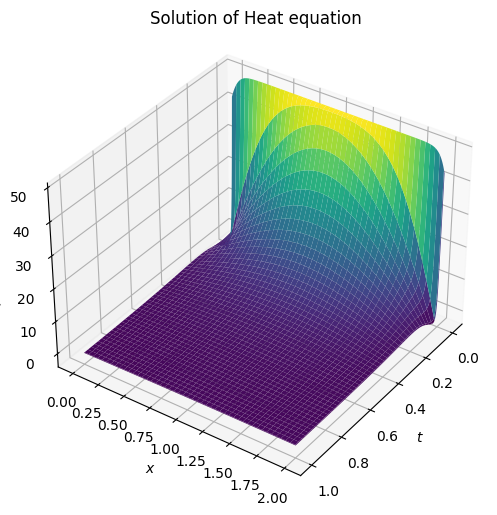

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = mlp(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Heat equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

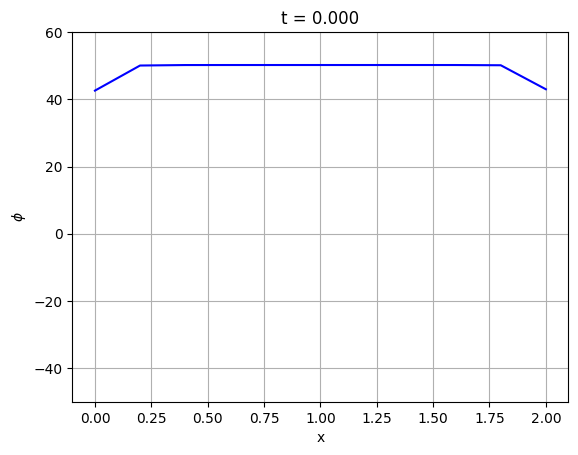

In [ ]:
# Set up meshgrid
N = 10
N_t=100
ps=[]
tspace = np.linspace(lb[0], ub[0], N_t + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)

from matplotlib import animation, rc
rc('animation', html='html5')

def update(i):
    ax.clear()
    ax.set_ylim(-50,60)
    T, X = np.meshgrid(tspace[i], xspace)
    Xgrid = np.vstack([T.flatten(),X.flatten()]).T
    upred=[]
    upred = mlp(tf.cast(Xgrid,DTYPE))
    upred=np.squeeze(upred.numpy())
    ax.plot(xspace,upred, "b")
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
    ax.set_title(f't = {tspace[i]:.3f}')
    ax.grid(True)
    return ax

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(tspace), interval=200)
anim

## Referencia:
https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=tXkjWO_yZEkj

https://math.stackexchange.com/questions/3872218/solution-to-a-partial-differential-equation-example

# Spring system
$L\frac{d^2i}{dt^2}+R\frac{di}{dt}+\frac{1}{C}i=0$

$i=0; t=0$

$L\frac{di}{dt}=V_0; t=0$

Consideramos: R=1.2, L=1.5,C=0.3 y $V_0=12$. La solución es:

$i(t)=5.57e^{-0.4t}sin(1.44t)$

In [ ]:
DTYPE='float32'

# Parámetros
R=tf.constant(1.2, dtype=DTYPE)
L=tf.constant(1.5, dtype=DTYPE)
C=tf.constant(0.3, dtype=DTYPE)
V0=tf.constant(12, dtype=DTYPE)

# Condición de i=0; i'
def fun_u_0(t):
  return 0*t

# PDE residual
def fun_r(i, i_t, i_tt):
    return L*i_tt+R*i_t+(1/C)*i

In [ ]:
# Data points
N_0=1
N_r=100

# Boundary
tmin=0
tmax=6

# Condición i=0; i'
t_0 = tf.ones((N_0,1), dtype=DTYPE)*tmin
i_0 = fun_u_0(t_0)

# Random points
t_r= tf.linspace(tmin,tmax, N_r);

In [ ]:
def init_model(num_hidden_layers=3, num_neurons_per_layer=60):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(shape=(1,)))

    # Normalizar entrada
    scaling_layer = tf.keras.layers.Lambda(lambda x: (x-tmin)/(tmax-tmin))
    model.add(scaling_layer)

    #Añadir las neuronas.
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('gelu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    model.summary()
    return model

#Modelo
mlp=init_model();
#Optimizador
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,4000],[1e-1,1e-2,5e-4])
optimizer = tf.keras.optimizers.Adam()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 60)                120       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 7501 (29.30 KB)
Trainable params: 7501 (29.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Parametros
epochs=7000
batch=10;

def step(mlp, t_0,t_r):
  # Calcular gradientes
  with tf.GradientTape(persistent=True) as tape:

    # Fijar variables
    tape.watch(t_0);

    # Primera perdida: i=0
    pred_0=mlp(t_0)
    loss_1=tf.reduce_mean(tf.square(pred_0));
    # Segunda perdida: i'=0
    dt_0=tape.gradient(pred_0, t_0)
    loss_2=tf.reduce_mean(tf.square(L*dt_0-V0))
    # Tercera perdida: EDO
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(t_r)
      pred_r=mlp(t_r);
      dt_r=tape2.gradient(pred_r, t_r);
      dtdt_r=tape2.gradient(dt_r,t_r);
      loss_3=fun_r(tf.cast(pred_r, dtype=DTYPE),tf.cast(dt_r, dtype=DTYPE),tf.cast(dtdt_r, dtype=DTYPE));
      loss_3=tf.reduce_mean(tf.square(loss_3))

    # Sumar Perdidas
    loss = loss_1+loss_2+loss_3

    # Calcular gradiente del modelo
    trainable=mlp.trainable_variables
    gradient=tape.gradient(loss, trainable);

    # Aplicar gradiente
    optimizer.apply_gradients(zip(gradient,trainable))
  del tape
  return loss


for i in range(epochs):
  for n in range(batch):
    j=n*batch
    loss=step(mlp,t_0,t_r[j:j+batch])
  if i % 50 == 0:
    print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 1.43096497e+02
It 00050: loss = 1.01563549e+00
It 00100: loss = 4.71785307e-01
It 00150: loss = 6.05514765e-01
It 00200: loss = 5.91482162e-01
It 00250: loss = 5.97531319e-01


KeyboardInterrupt: ignored

In [ ]:
t_init2 = np.array([0.0])
t_init2 = tf.convert_to_tensor(t_init2)
t_init2 = tf.reshape(t_init2, [1, 1])
t_init2

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>

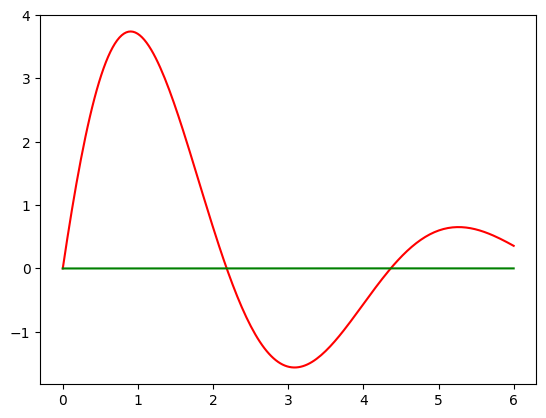

In [ ]:
import matplotlib.pyplot as plt
N_t=200
t=np.linspace(tmin,tmax,200);

# Real solution
i = 5.57*np.exp(-0.4*t)*np.sin(1.44*t)
plt.plot(t,i,'r')

# Predicted
i=mlp(t);
plt.plot(t,i, 'g')

# Representar
plt.show()

In [ ]:
o=mlp(tf.constant([0]))
tf.reduce_mean(tf.square(o))

<tf.Tensor: shape=(), dtype=float32, numpy=2.4728072>

# Inverse Problem PINN

In [ ]:
# Generamos una serie de valores reales R=1.2 L=1.5 C=0.3 V0=12
# Parámetros
tmin=0
tmax=6
N_t=50
rlc_lr=0.001
adam_lr=0.001
V0=tf.constant(12, tf.float64)
DTYPE="float64"

t=np.linspace(tmin,tmax,N_t)
i=5.57*np.exp(-0.4*t)*np.sin(1.44*t)

t=tf.constant(t, dtype=DTYPE);
i=tf.constant(i, dtype=DTYPE)
# Condición de i=0; i'
def fun_u_0(t):
  return 0*t

# PDE residual
def fun_r(i, i_t, i_tt,trainable):
    R=trainable[0]
    L=trainable[1]
    C=trainable[2]
    return L*i_tt+R*i_t+(1/C)*i
## Trainable format 1º: R 2º:L 3º:C

# Data points
N_0=1

# Condición i=0; i'=0
t_0 = tf.ones((N_0,1), dtype=DTYPE)*tmin
i_0 = fun_u_0(t_0)

In [ ]:
def init_model(num_hidden_layers=2, num_neurons_per_layer=128):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(shape=(1,)))

    # Normalizar entrada
    scaling_layer = tf.keras.layers.Lambda(lambda x: (x-tmin)/(tmax-tmin))
    model.add(scaling_layer)

    #Añadir las neuronas.
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('gelu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    model.summary()
    return model

#Modelo
mlp=init_model();
#Optimizador
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,4000],[1e-1,1e-2,5e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate=adam_lr)

# Variables a observar adicionales
R=tf.Variable([0.1], trainable=True)
L=tf.Variable([0.1],trainable=True)
C=tf.Variable([0.1],trainable=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
 dense_3 (Dense)             (None, 128)               256       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16897 (66.00 KB)
Trainable params: 16897 (66.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Debugger

In [ ]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
# Parametros
epochs=1000
batch=1;
debug=False

def step(mlp, t_0,t_coloc,i_coloc, debug=False):
  # Calcular gradientes
  with tf.GradientTape(persistent=True) as tape:

    # Fijar variables
    tape.watch(t_0);

    # Primera perdida: i=0
    pred_0=mlp(t_0)
    pred_0=tf.cast(pred_0,tf.float64)
    loss_1=tf.reduce_mean(tf.square(pred_0));

    # Segunda perdida: i'=0
    dt_0=tape.gradient(pred_0, t_0)
    L64=tf.cast(L, tf.float64);
    loss_2=tf.reduce_mean(tf.square(L64*dt_0-V0))

    # Tercera perdida: EDO
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(t_coloc)
      pred_r=mlp(t_coloc);
      dt_r=tape2.gradient(pred_r, t_coloc);
      dtdt_r=tape2.gradient(dt_r,t_coloc);
      # Tenemos que pasar al residuo los valores actuales de la variable
      variables=tf.concat([R,L,C],axis=0)
      R64=tf.cast(R, tf.float64)
      C64=tf.cast(C,tf.float64)
      L64=tf.cast(L,tf.float64)
      pred_r=tf.cast(pred_r,dtype=DTYPE)
      #loss_3=fun_r(tf.cast(pred_r, dtype=DTYPE),tf.cast(dt_r, dtype=DTYPE),tf.cast(dtdt_r, dtype=DTYPE),variables);
      loss_3=R64*dtdt_r+L64*dt_r+(1/C64)*pred_r
      loss_3=tf.reduce_mean(tf.square(loss_3))

    # Cuarta perdida:
    # Diferencia entre los puntos i_coloc y lo que da la red en t_coloc
    tape.watch(t_coloc)
    pred_r=mlp(t_coloc);
    pred_r=tf.cast(pred_r,dtype=DTYPE)
    loss_4=tf.reduce_mean(tf.square(pred_r-i_coloc))


    # Sumar Perdidas
    loss = loss_1+loss_2+loss_3+loss_4*10

    # Debug
    if debug:
      print("Loss_1: {} \n Loss_2: {} \n Loss_3: {} \n Loss_4: {}".format(loss_1.numpy(),loss_2.numpy(),loss_3.numpy(),loss_4.numpy()))

    # Calcular gradiente del modelo
    trainable=mlp.trainable_variables
    trainable.append(R)
    trainable.append(L)
    trainable.append(C)
    gradient=tape.gradient(loss, trainable);
    #print("FIN GRADIENTE")
    #print(gradient)
    # Aplicar gradiente
    optimizer.apply_gradients(zip(gradient,trainable))
    #ipdb.set_trace()
    R.assign_sub(gradient[6] * rlc_lr)
    L.assign_sub(gradient[7] * rlc_lr)
    C.assign_sub(gradient[8] * rlc_lr)
    #ipdb.set_trace()
  del tape
  return R,L,C, loss

R_plot=[]
L_plot=[]
C_plot=[]
batch_per_epoch=math.floor(len(t)/batch)
for k in range(epochs):
  for n in range(batch_per_epoch):
    j=n*batch
    #print(j)
    R_data, L_data,C_data,loss=step(mlp,t_0,t[j:j+batch],i[j:j+batch])
    R_plot.append(R_data); L_plot.append(L_data); C_plot.append(C_data)
  if k % 50 == 0:
    print('It {:05d}: loss = {:10.8e}'.format(k,loss))

print("R: {} \n, L: {} \n, C:{}".format(R.numpy(),L.numpy(),C.numpy()))

It 00000: loss = 1.44829484e+02
It 00050: loss = 2.53469954e+00
It 00100: loss = 2.58667436e+00
It 00150: loss = 2.97304677e+00
It 00200: loss = 3.12642572e+00
It 00250: loss = 2.64267136e+00
It 00300: loss = 2.92021935e+00
It 00350: loss = 2.94803784e+00
It 00400: loss = 3.01603377e+00
It 00450: loss = 3.08367738e+00
It 00500: loss = 3.16123255e+00
It 00550: loss = 3.26400791e+00
It 00600: loss = 3.34596355e+00
It 00650: loss = 3.55306813e+00
It 00700: loss = 3.09543677e+00
It 00750: loss = 3.25977711e+00
It 00800: loss = 3.32857609e+00
It 00850: loss = 3.39843700e+00
It 00900: loss = 2.97360130e+00
It 00950: loss = 2.91585659e+00
R: [-4.3779125] 
, L: [-5.904309] 
, C:[11.296495]


# Heat Equation 2D

$u_t-\nu\cdot (u_{xx}+u_{yy})=0 \quad\Omega  \times (0,T)$

$u=0 \quad \partial\Omega \times (0,T)$

$u(x,0)=x_1(1-x_1)x_2(1-x_2) \quad \Omega$

NameError: ignored

In [ ]:
2DTYPE='float32'

nu = 1
def fun_u_0(x):
  return 16*x[:, 0:1]*(1-x[:,0:1])*x[:,1:2]*(1-x[:,1:2])

def fun_u_b(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
# Define residual of the PDE
def fun_r(u_t,u_xx, u_yy):
    return u_t -u_xx-u_yy

In [ ]:
# Data points
N_0=15
N_r=15
N_b=15
N_t=10

# Boundary
tmin=0.
tmax=0.1
xmin=0.
xmax=1.
ymin=0.
ymax=1.

# Lower bound y upper bound
lb=tf.constant([xmin, ymin,tmin], dtype=DTYPE);
up=tf.constant([xmax,ymax,tmax],dtype=DTYPE)

# Inicial
x_0 = tf.linspace(xmin, xmax, N_0)
y_0 = tf.linspace(ymin, ymax, N_0)
X, Y = tf.meshgrid(x_0, y_0)
X_0 = tf.stack([tf.reshape(X, [-1]), tf.reshape(Y, [-1]), tf.zeros_like(tf.reshape(X, [-1]))], axis=1)
u_0 = fun_u_0(X_0)

# Boundary
border=tf.linspace(xmin,xmax,N_b);
t_b=tf.linspace(tmin, tmax, N_t)
border, t_b = tf.meshgrid(border, t_b)
zero_border=tf.ones_like(border)

# Tipo: (x,1,random)
sup= tf.stack([tf.reshape(border, [-1]), tf.ones_like(tf.reshape(border, [-1])),tf.reshape(t_b, [-1])], axis=1)
# Tipo: (x,0,random)
inf=tf.stack([tf.reshape(border, [-1]), tf.zeros_like(tf.reshape(border, [-1])),tf.reshape(t_b, [-1])], axis=1)
# Tipo: (0,x,random)
izq=tf.stack([tf.zeros_like(tf.reshape(border, [-1])),tf.reshape(border, [-1]), tf.reshape(t_b, [-1])], axis=1)
# Tipo: (1,x,random)
der=tf.stack([tf.ones_like(tf.reshape(border, [-1])),tf.reshape(border, [-1]), tf.reshape(t_b, [-1])], axis=1)

X_b=tf.concat([sup,inf,izq,der],axis=0)
u_b=fun_u_b(X_b)

# Random
x_r=tf.linspace(xmin,xmax, N_r);
y_r=tf.linspace(ymin,ymax,N_r);
t_r=tf.linspace(tmin,tmax,N_t);
X,Y,T=tf.meshgrid(x_r,y_r,t_r)

X_r = tf.stack([tf.reshape(X, [-1]), tf.reshape(Y, [-1]), tf.reshape(T, [-1])], axis=1)

In [ ]:
def init_model(num_hidden_layers=3, num_neurons_per_layer=60):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(shape=(3,)))

    # Normalizar entrada
    scaling_layer = tf.keras.layers.Lambda(lambda x: (x-lb)/(up-lb))
    model.add(scaling_layer)

    #Añadir las neuronas.
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('gelu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    model.summary()
    return model

#Modelo
mlp=init_model();
#Optimizador
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,4000],[1e-1,1e-2,5e-4])
optimizer = tf.keras.optimizers.Adam()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 60)                240       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 7621 (29.77 KB)
Trainable params: 7621 (29.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Parámetros
epochs=4000
batch=50


def step(mlp, X_0,u_0,X_b,u_b,X_r):
  with tf.GradientTape(persistent=True) as tape:
    # Calculamos el error inicial
    u_0_pred=mlp(X_0);
    loss_1=tf.reduce_mean(tf.square(u_0_pred-u_0))*100;

    # Calculamos el error del boundary
    u_b_pred=mlp(X_b);
    loss_2=tf.reduce_mean(tf.square(u_b_pred-u_b))*200;
    # Calculamos el error de x_r
    # Dividimos en las variables x, y, t
    x,y,t=X_r[:,0], X_r[:,1],X_r[:,2];
    tape.watch(x);
    tape.watch(y)
    tape.watch(t)

    u_r_pred=mlp(tf.stack([x,y,t],axis=1));

    # Calculamos las derivadas
    u_x=tape.gradient(u_r_pred,x);
    u_y=tape.gradient(u_r_pred,y);
    u_t=tape.gradient(u_r_pred,t);

    u_xx=tape.gradient(u_x,x);
    u_yy=tape.gradient(u_y,y);

    loss_3=tf.reduce_mean(tf.square(fun_r(u_t,u_xx,u_yy)))

    # Calculamos la perdida total
    loss = loss_1+loss_2+loss_3

    # Calcular gradiente del modelo
    trainable=mlp.trainable_variables
    gradient=tape.gradient(loss, trainable);

    # Aplicar gradiente
    optimizer.apply_gradients(zip(gradient,trainable))
  del tape
  return loss


for i in range(epochs):
  selected_indices1 = tf.random.shuffle(tf.range(X_0.shape[0]))[:batch]
  selected_indices2 = tf.random.shuffle(tf.range(X_b.shape[0]))[:batch]
  selected_indices3 = tf.random.shuffle(tf.range(X_r.shape[0]))[:batch]
  # División batch
  loss=step(mlp,tf.gather(X_0, selected_indices1),tf.gather(u_0, selected_indices1),tf.gather(X_b, selected_indices2),tf.gather(u_b, selected_indices2),tf.gather(X_r, selected_indices3))
  #loss=step(mlp,X_0,u_0,X_b,u_b,X_r)
  if i % 50 == 0:
    print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 1.53242618e-01
It 00050: loss = 1.36615291e-01
It 00100: loss = 1.33328021e-01
It 00150: loss = 1.38205871e-01
It 00200: loss = 1.24567553e-01
It 00250: loss = 1.37411922e-01
It 00300: loss = 1.12591513e-01
It 00350: loss = 1.21264726e-01
It 00400: loss = 1.09232910e-01
It 00450: loss = 1.06669009e-01
It 00500: loss = 8.41010585e-02
It 00550: loss = 1.02466412e-01
It 00600: loss = 1.02677748e-01
It 00650: loss = 9.08655226e-02
It 00700: loss = 1.10218495e-01
It 00750: loss = 7.34415948e-02
It 00800: loss = 9.13822204e-02
It 00850: loss = 1.10296048e-01
It 00900: loss = 1.13798901e-01
It 00950: loss = 1.04421720e-01
It 01000: loss = 8.22477341e-02
It 01050: loss = 7.99948275e-02
It 01100: loss = 1.14670783e-01
It 01150: loss = 8.07156265e-02
It 01200: loss = 6.63090795e-02
It 01250: loss = 1.06592663e-01
It 01300: loss = 8.56773928e-02
It 01350: loss = 6.96765780e-02
It 01400: loss = 7.74992704e-02
It 01450: loss = 5.44912852e-02
It 01500: loss = 6.88791871e-02
It 01550

## Entrenamiento:

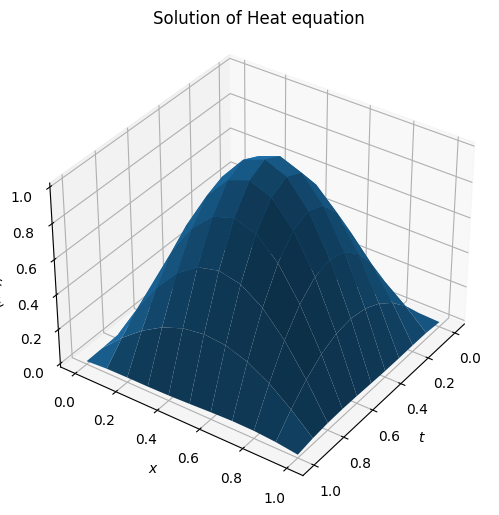

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
rc('animation', html='html5')

# Set up meshgrid
N = 10
N_t=100
t_anim= np.linspace(tmin, tmax, N_t + 1)
def update(i):
  ax.clear()
  ax.set_zlim(0,1)
  tspace=np.ones(((N+1)*(N+1),1))*t_anim[i]
  xspace = np.linspace(xmin, xmax, N + 1)
  yspace = np.linspace(xmin, xmax, N + 1)
  X, Y= np.meshgrid(xspace, yspace)
  Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
  Xgrid=np.hstack((Xgrid, tspace))
  ax.view_init(35,35)
  # Determine predictions of u(t, x)
  upred = mlp(tf.cast(Xgrid,DTYPE))

  # Reshape upred
  U = upred.numpy().reshape(N+1,N+1)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.set_zlabel('$u_\\theta(t,x)$')
  ax.set_title('Solution of Heat equation');
  ax.plot_surface(X,Y,U)
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(fig, update, frames=len(t_anim), interval=200)
anim

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [ ]:
# Saving Model
mlp.save("Heat-EQ-2D.keras")

Si se compara con la creada con deepxde es igualita.

## Rafa-Lib

In [ ]:
# Install the PINN library "DeepXDE"
!pip install deepxde
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.4 MB/s eta 0:00:00


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# PDE data and useful functions

end_time = 0.1

def pde_residual(x, u):
  """
  * x: network input. 3-dimensional vector where x[:,0], x[:,1] are respectively
    the x and y-coordinates and x[:,2] is the t-coordinate.
  * u: network output, i.e. solution u(x,y,t)
  """
  du_xx = dde.grad.hessian(u, x, i=0, j=0)
  du_yy = dde.grad.hessian(u, x, i=1, j=1)
  du_t = dde.grad.jacobian(u, x, j=2)
  coefficient = 1
  return du_t - coefficient * (du_xx + du_yy)

def boundary_initial(X, on_initial):
    x,y,t = X
    return on_initial and np.isclose(t, 0)

def boundary_dirichlet(X, on_boundary):
    return on_boundary
    #Lo siguiente no funciona, no sé por qué...
    # x,y,t = X
    # return on_boundary and (np.isclose(x, 0) or np.isclose(x, 1) or np.isclose(y, 0) or np.isclose(y, 1))

def init_condition(X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    C = 2**4 # Normalize results in [0,1]^2
    return C * x*(1-x)*y*(1-y)

def func_zero(X):
    return 0 #np.zeros((len(X),1))

# Data for the uN

num_domain =  200 #30000
num_boundary = 200 #8000
num_initial = 100 #20000
layer_size = [3] + [60] * 3 + [1]
activation_func = "tanh"
initializer = "Glorot uniform"
lr = 1e-3 # Larning rate
epochs = 2000
batch_size_ = 512

# Applying Loss weights as given below
# [PDE Loss, BC, IC loss]
loss_weights = [10, 100, 1]

# Space-time domain
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary and initial conditions
bc = dde.DirichletBC(geomtime, func_zero, boundary_dirichlet)
ic = dde.IC(geomtime, init_condition, boundary_initial)

# Define PINN neural network
data = dde.data.TimePDE(
    geomtime, pde_residual, [bc, ic], num_domain=num_domain, num_boundary=num_boundary, num_initial=num_initial)
net = dde.maps.FNN(layer_size, activation_func, initializer)
#net.apply_output_transform(lambda x, y: abs(y))
model = dde.Model(data, net)

In [ ]:
# Build and train the model
model.compile("adam", lr=lr, loss_weights=loss_weights)
loss_history, train_state = model.train(iterations=epochs, batch_size = batch_size_)

model.compile("L-BFGS", loss_weights=loss_weights)
# dde.optimizers.set_LBFGS_options(
#    maxcor=50,
#)
losshistory, train_state = model.train(batch_size = batch_size_)

Compiling model...
Building feed-forward neural network...
'build' took 0.058191 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.499307 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.91e-01, 8.32e+00, 1.72e-01]    [1.91e-01, 8.32e+00, 1.72e-01]    []  
1000      [1.27e-03, 4.52e-03, 2.70e-01]    [1.27e-03, 4.52e-03, 2.70e-01]    []  
2000      [1.78e-03, 1.03e-02, 2.59e-01]    [1.78e-03, 1.03e-02, 2.59e-01]    []  

Best model at step 2000:
  train loss: 2.71e-01
  test loss: 2.71e-01
  test metric: []

'train' took 29.066616 s

Compiling model...
'compile' took 2.492017 s

Training model...

Step      Train loss                        Test loss                         Test metric
2000      [1.78e-03, 1.03e-02, 2.59e-01]    [1.78e-03, 1.03e-02, 2.59e-01]    []  
3000      [2.11e-02, 4.81e-02, 8.13e-02]    [2.11e-02, 4.81e-02, 8.13e-02]        
4000      [9.99e-03, 1.04e-02, 2.09e-03]    [9.99e-03, 1.04e-02, 2.09e-03]        
5000      [2.27e-03, 1.75e-03, 1.11e-03]    [2.27e-03, 1.75e-03, 1.11e-03]        
6000      [6

NameError: ignored

Error in callback <function _draw_all_if_interactive at 0x7b8752f05990> (for post_execute):


NameError: ignored

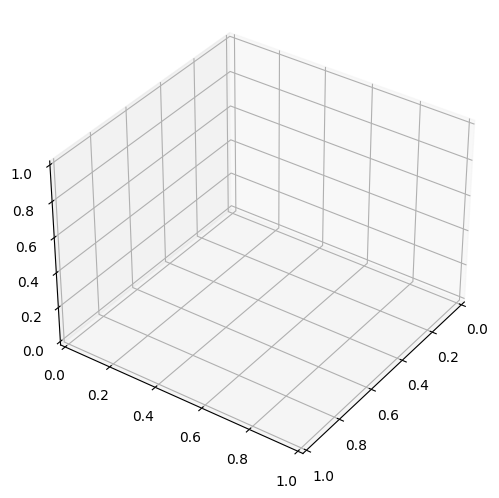

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
rc('animation', html='html5')

# Set up meshgrid
N = 10
N_t=100
t_anim= np.linspace(0, 0.1, N_t + 1)
def update(i):
  ax.clear()
  ax.set_zlim(0,1)
  tspace=np.ones(((N+1)*(N+1),1))*t_anim[i]
  xspace = np.linspace(0, 1, N + 1)
  yspace = np.linspace(0, 1, N + 1)
  X, Y= np.meshgrid(xspace, yspace)
  Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
  Xgrid=np.hstack((Xgrid, tspace))
  ax.view_init(35,35)
  # Determine predictions of u(t, x)
  upred = model.predict(Xgrid)

  # Reshape upred
  U = upred.reshape(N+1,N+1)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.set_zlabel('$u_\\theta(t,x)$')
  ax.set_title('Solution of Heat equation');
  ax.plot_surface(X,Y,U)
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(fig, update, frames=len(t_anim), interval=200)
anim

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [ ]:
mlp=tf.keras.models.load_model('Heat-EQ-2D.keras', safe_mode=False)